# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цели исследования:** 
1. Построить систему выявления и очистки данных от аномалий
2. Определить рыночную стоимость жилья, найти факторы, влияющие на неё

**Ход исследования:** 

Полученные данные необходимо проверить на качество - привести данные к необходимому типу, избавиться от явных и неявных дублей, избавиться от нетипичных значений, искажающих картину. После этого будет возможно приступить к исследовательскому анализу данных.

**Этапы:** 
- Получение данных
- Предобработка данных (изменение типов, удаление дубликатов и аномалий, расчет дополнительных столбцов)
- Изучение параметров очищенных и обогащенных данных
- Выявление корреляций и зависимостей
- Общий вывод

### Изучаем датасет

#### Датасет

In [1]:
import pandas as pd
import datetime
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

#### Общая информация

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


#### Строим общую гистограмму для всех числовых столбцов таблицы

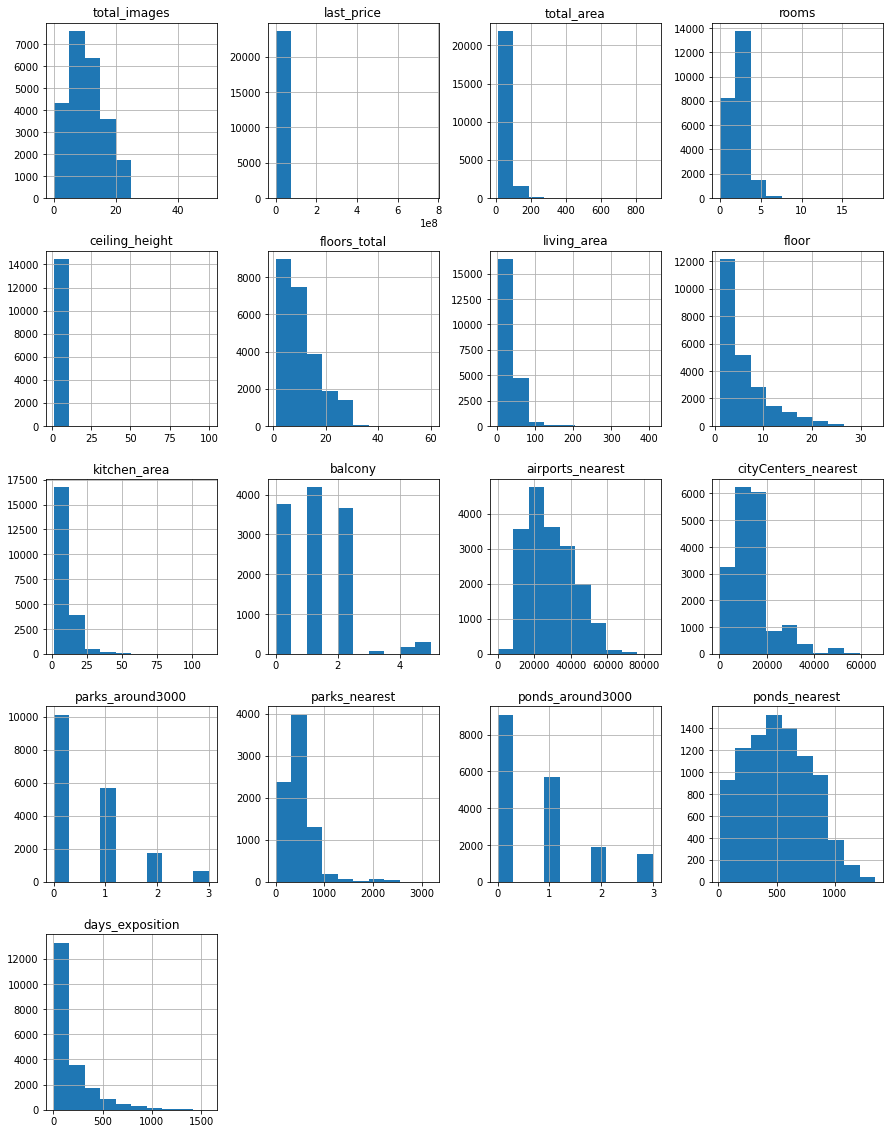

In [4]:
data.hist(figsize=(15, 20));

В данных видны пропущенные значения и аномалии, которые могут затруднить исследование и исказить картину. Прежде, чем приступать к исследованию, нужно от них избавиться.

### Предобработка данных

#### Работа с пропусками

In [5]:
# Посмотрим, в каких колонках есть пропуски
(pd.DataFrame(data.isna().mean())
 .sort_values(0, ascending=False)
 .style.background_gradient('coolwarm')
 .format(formatter={0: '{0:.0%}'})
 .set_caption('Доля пропусков в колонках'))

,0
is_apartment,88%
parks_nearest,66%
ponds_nearest,62%
balcony,49%
ceiling_height,39%
airports_nearest,23%
cityCenters_nearest,23%
ponds_around3000,23%
parks_around3000,23%
days_exposition,13%


Если человек не указал количество балконов, скорее всего их нет. То же самое справедливо для апартамента - если не указано, что квартира является апартаментами, вероятнее всего, она ими не является.

In [6]:
data['is_apartment'].fillna(False, inplace=True)
data['balcony'].fillna(0, inplace=True)

Изучая данные, мы обнаружили, что существуют квартиры с количеством комнат - 0. Это странно. Стоит переписать значения этих комнат на 1.

In [7]:
data.loc[data['rooms'] == 0, 'rooms']= 1

Чтобы  заполнить пропуски в *living_area* и *kitchen_area* можно посчитать, какую обычно долю от общей площади они занимают в квартирах с таким же количеством комнат.

In [8]:
area_share = data[(~data['kitchen_area'].isna()) 
                  & 
                  (~data['living_area'].isna())].pivot_table(index='rooms', 
                                                              values=['living_area', 'kitchen_area', 'total_area'],
                                                              aggfunc='sum')
area_share['kitchen_share'] = area_share['kitchen_area'] / area_share['total_area']
area_share['living_share'] = area_share['living_area'] / area_share['total_area']

И для пропущенных значений вычислить площадь кухни и жилых помещений.

In [9]:
for i in area_share.index:
    data.loc[(data['living_area'].isna())
              &
              (data['rooms'] == i), 'living_area'] =  data.loc[(data['living_area'].isna())
                                                               &
                                                               (data['rooms'] == i), 'total_area'] * area_share.loc[i, 'living_share']
    data.loc[(data['kitchen_area'].isna())
              &
              (data['rooms'] == i), 'kitchen_area'] =  data.loc[(data['kitchen_area'].isna())
                                                                &
                                                                (data['rooms'] == i), 'total_area'] * area_share.loc[i, 'kitchen_share']

Для потолков возьмём медианное значение

In [10]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

In [11]:
# Посмотрим, в каких колонках остались пропуски
(pd.DataFrame(data.isna().mean())
 .sort_values(0, ascending=False)
 .style.background_gradient('coolwarm')
 .format(formatter={0: '{0:.0%}'})
 .set_caption('Доля пропусков в колонках'))

,0
parks_nearest,66%
ponds_nearest,62%
airports_nearest,23%
cityCenters_nearest,23%
ponds_around3000,23%
parks_around3000,23%
days_exposition,13%
floors_total,0%
locality_name,0%
kitchen_area,0%


Заполнить остальные пропуски на текущих данных было бы возможно, будь у нас в наличии географические координаты. 

*days_exposition* оставим с пропусками. Квартира еще в продаже, заполнять эту колонку нечем.

#### Изменение типов

In [12]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Данные в основном в порядке за некоторым исключением.
- Имеет смысль преобразовать в дату колонку *first_day_exposition*
- *balcony* стоит преобразовать в тип данных integer 

In [13]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['balcony'] = data['balcony'].astype('int')

In [14]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

#### Дубликаты

In [15]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют, но присутствуют неявыне дубликаты. Встречаются как *чистые* названия населенных пунктов, например "Мурино", так и тип + название, например "посёлок Мурино". Очистим названия, чтобы удалить неявные дубликаты

In [16]:
data['locality_name'] = (data['locality_name']
                         .str.replace('посёлок ', '')
                         .str.replace('деревня ', '')
                         .str.replace('поселок ', '')
                         .str.replace('городского типа ', '')
                         .str.replace('село ', '')
                         .str.replace('городской ', '')
                         .str.replace('при железнодорожной ', '')
                         .str.replace('имени ', '')
                         .str.replace('станции ', '')
                         .str.replace('садовое товарищество ', '')
                         .str.replace('садоводческое некоммерческое товарищество ', '')
                         .str.replace('коттеджный ', '')
                         .str.replace('Пансионат ', '')
                         .str.replace('Форт ', '')
                         .str.replace('Платформа ', '')
                        )

#### Аномалии

In [17]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,23699.000000,23699.000000,23699.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.078948,2.724358,10.673824,34.594319,5.892358,10.529404,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.066196,0.988298,6.597173,22.653959,4.885249,5.834812,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.700000,2.000000,7.100000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.181770,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,11.927536,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,124.634963,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Настораживают 19-комнатные дома в 900 кв.м. с жилой площадью 409 кв.м. и площадью кухни в 124 кв. м. Также застораживают 100-метровые потолки

(2.0, 3.0)

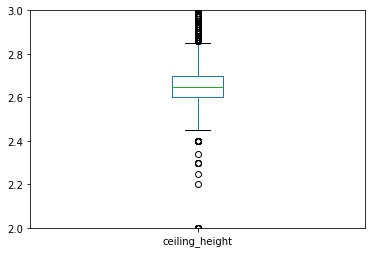

In [18]:
ax = data['ceiling_height'].plot(kind='box')
ax.set_ylim(2, 3)

In [19]:
# Доля потолков выше 3.5 метров
round(data[data['ceiling_height'] > 3.5].shape[0] / data.shape[0] * 100, 1)

1.3

Потолки выше, чем 3.5 метра выглядят аномально и, встречаются лишь в 1.3% случаев. Также согласно современных правил потолки не могут быть ниже 2.5 метров. Удалим эти данные из датасета

In [20]:
data = data[(data['ceiling_height'] < 3.5) & (data['ceiling_height'] > 2.5)]

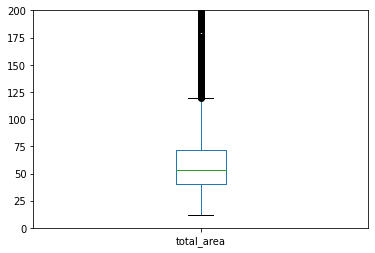

In [21]:
ax = data['total_area'].plot(kind='box')
ax.set_ylim(0, 200);

Жильё, площадью больше 125 метров считается выбросами. Но всё же таие квартиры вполне могут быть, если это жильё премиум-класса. Уберем из датасета квартиры площадью больше 200 кв. м.

In [22]:
data = data.drop(data[data['total_area'] > 200].index)

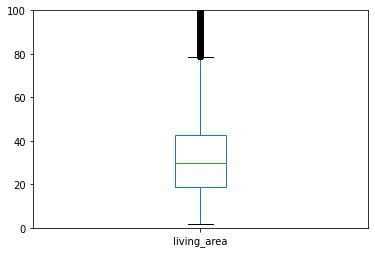

In [23]:
ax = data['living_area'].plot(kind='box')
ax.set_ylim(0, 100);

Жилая площадь больше 80 кв. м. считается аномальной. Поскольку мы несколько подняли границу для возможной общей площади, поднимем её и для жилой. Оставим квартиры не более 100 кв. м. жилой площади

In [24]:
data = data.drop(data[data['living_area'] > 100].index)

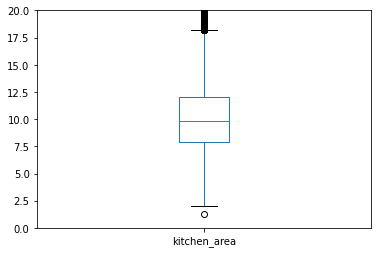

In [25]:
ax = data['kitchen_area'].plot(kind='box')
ax.set_ylim(0, 20);

Кухни больше 18 кв. м. считаюется аномальными. Поскольку мы несколько подняли границу для возможной общей площади, поднимем её и для жилой. Оставим квартиры не более 20 кв. м. жилой площади

In [26]:
data = data.drop(data[data['kitchen_area'] > 20].index)

In [27]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,18564.000000,1.856400e+04,18564.000000,18564.000000,18564.000000,18482.000000,18564.000000,18564.000000,18564.000000,18564.000000,14155.000000,14174.000000,14175.000000,6076.000000,14175.000000,7118.000000,16394.000000
mean,9.713963,5.668644e+06,56.535898,1.978291,2.703286,11.401309,32.202939,6.219565,9.918972,0.605796,28558.887248,14283.804219,0.581235,496.758558,0.764656,522.041023,178.290106
std,5.630534,4.261109e+06,22.804395,0.935173,0.149196,6.865677,15.569399,5.119333,3.164090,0.968646,12470.798706,8313.897104,0.781841,354.691601,0.928246,275.462414,217.373889
min,0.000000,4.300000e+05,12.000000,1.000000,2.510000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,287.000000,0.000000,1.000000,0.000000,13.000000,2.000000
25%,6.000000,3.478750e+06,40.000000,1.000000,2.650000,5.000000,18.336163,2.000000,7.700000,0.000000,18459.000000,9623.750000,0.000000,288.000000,0.000000,303.000000,45.000000
50%,9.000000,4.650000e+06,51.500000,2.000000,2.650000,9.000000,30.000000,5.000000,9.574707,0.000000,26831.000000,13200.000000,0.000000,452.000000,1.000000,505.000000,94.000000
75%,14.000000,6.600000e+06,68.000000,3.000000,2.700000,16.000000,41.589201,9.000000,11.610321,1.000000,36771.000000,16316.000000,1.000000,616.000000,1.000000,729.000000,227.000000
max,42.000000,1.240000e+08,190.000000,7.000000,3.490000,60.000000,100.000000,33.000000,20.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1572.000000


**Вывод:** удалив аномалии нам станет проще анализировать тенденции. Снизится вероятность того, что искажения повлияют на наши выводы.


### Новые столбцы

Добавим новые столбцы согласно заданию. Нам нужны: 
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [28]:
# Стоимость квадратного метра
data['meter_price'] = data['last_price'] / data['total_area']

# Группа колонок с датами. 
data['exposition_weekday'] = pd.to_datetime(data['first_day_exposition']).dt.weekday
data['exposition_month'] = pd.to_datetime(data['first_day_exposition']).dt.month
data['exposition_year'] = pd.to_datetime(data['first_day_exposition']).dt.year
data[['first_day_exposition', 'exposition_weekday', 'exposition_month', 'exposition_year']].head()

,first_day_exposition,exposition_weekday,exposition_month,exposition_year
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
5,2018-09-10,0,9,2018
6,2017-11-02,3,11,2017
7,2019-04-18,3,4,2019


In [29]:
# Тип этажа квартиры
def floor_type(df):
    if df['floor'] == 1:
        return 'первый'
    elif df['floor'] == df['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

for floor in data['floor_type'].unique():
    display(data[data['floor_type'] == floor][['floor', 'floors_total', 'floor_type']].head(1))

,floor,floors_total,floor_type
1,1,11.0,первый


,floor,floors_total,floor_type
2,4,5.0,другой


,floor,floors_total,floor_type
12,5,5.0,последний


In [30]:
# расстояние до центра города в километрах 
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round().astype('int', errors='ignore')
data[['cityCenters_nearest', 'cityCenters_nearest_km']].head()

,cityCenters_nearest,cityCenters_nearest_km
1,18603.0,19.0
2,13933.0,14.0
5,NaN,NaN
6,19143.0,19.0
7,11634.0,12.0


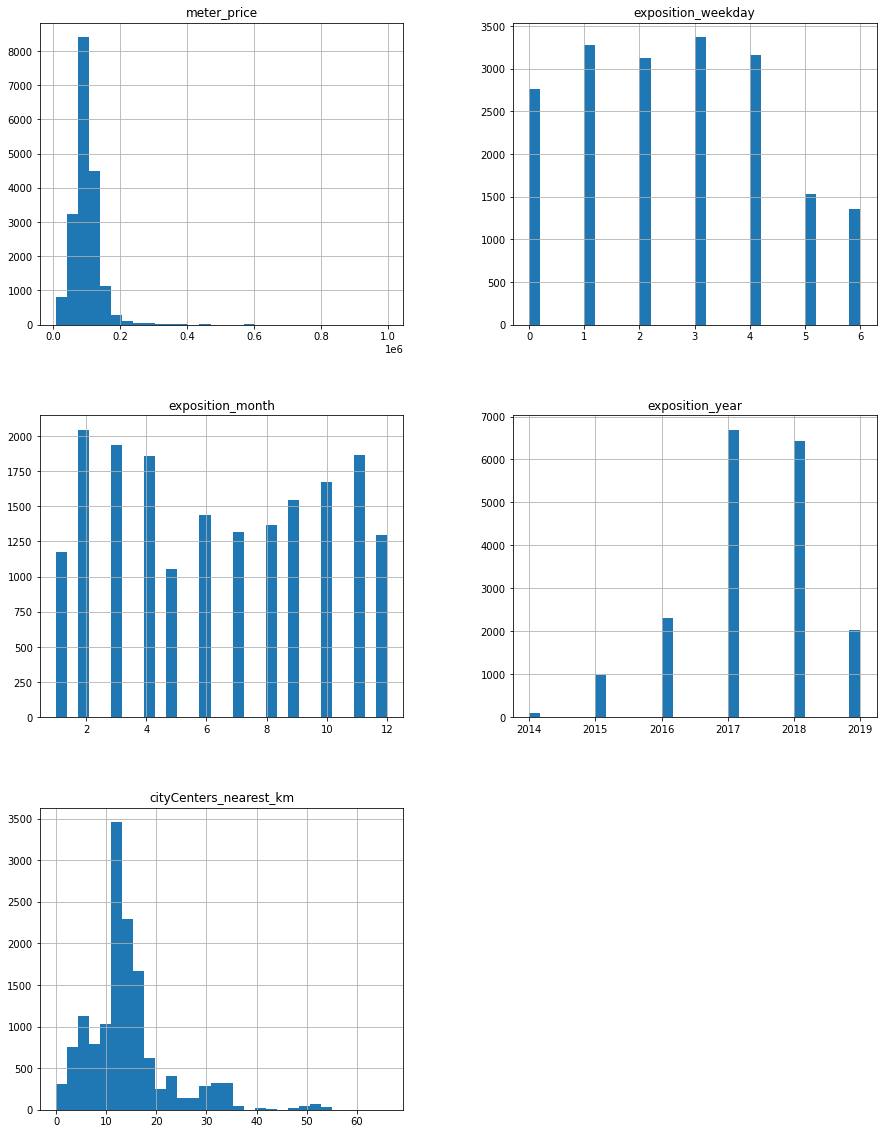

In [31]:
data[['meter_price', 
      'exposition_weekday', 
      'exposition_month', 
      'exposition_year', 
      'floor_type',
      'cityCenters_nearest_km']].hist(bins=30, figsize=(15, 20));

In [32]:
data['cityCenters_nearest_km'].max()

66.0

In [33]:
data['meter_price'].min()

7962.962962962963

In [34]:
data[(data['exposition_year'] == 2019)]['exposition_month'].value_counts()

4    682
3    609
2    398
1    311
5     38
Name: exposition_month, dtype: int64

*meter_price* имеет пик в районе 100000 рублей. Выглядит обычно, учитывая, что много объявлений приходится на Санкт-Петербург.

*exposition_weekday* демонстрирует, что в выходные люди публикуют меньше объявлений, чем в будни. Для любой интернет-активности это нормально.

*exposition_month* показывает, что большее количество публикаций приходится на холодные сезоны, за исключением просадки в канун нового года и новогодние праздники, что, опять же, нормально для любой интернет активности. Также на данные по месяца сыграл тот факт, что в представленном датасете 2019 год отражен не полностью

*exposition_year* демонстрирует рост количества объявлений от года к году. Снижение в 19-м году обусловлено тем, что в датасете он представлен не полностью.

*cityCenters_nearest_km* самый высокий пик связан скорее всего с тем, что большинство объявлений в датасете из Санкт-Петербурга. С чем связан второй пик, сложно сказать. Возможно, популярность сервиса в одном из районов.

### Исследовательский анализ данных

#### Изучим параметры объектов

- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

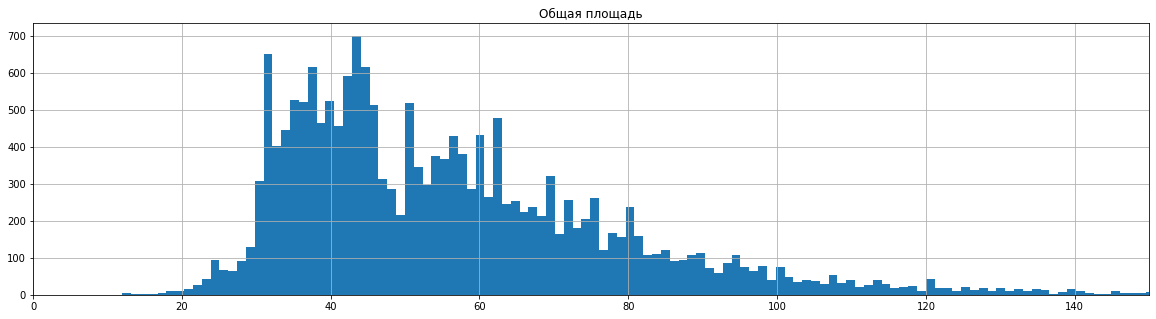

In [35]:
ax = data['total_area'].hist(bins=150, figsize=(20, 5))
plt.title('Общая площадь')
ax.set_xlim(0, 150);

*Общая площадь* демонстрирует множественные пики. Возможно, мы наблюдаем жилые комплесы со своим стандартнами площадей.

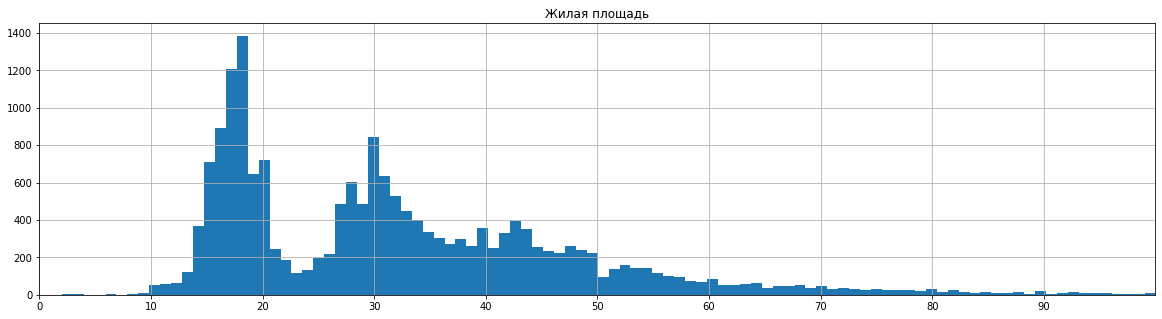

In [36]:
ax = data['living_area'].hist(bins=100, figsize=(20, 5))
plt.title('Жилая площадь')
ax.set_xlim(0, 100)
plt.xticks(np.arange(0, 100, 10));

У *Жилой площади* необычное распределение с двумя пиками - в районе 18 и 30 кв. м. Самый высокий пик в районе 15 кв. м. свидетельствует в пользу гипотезы, что большинство представленных квартир однокомнатные

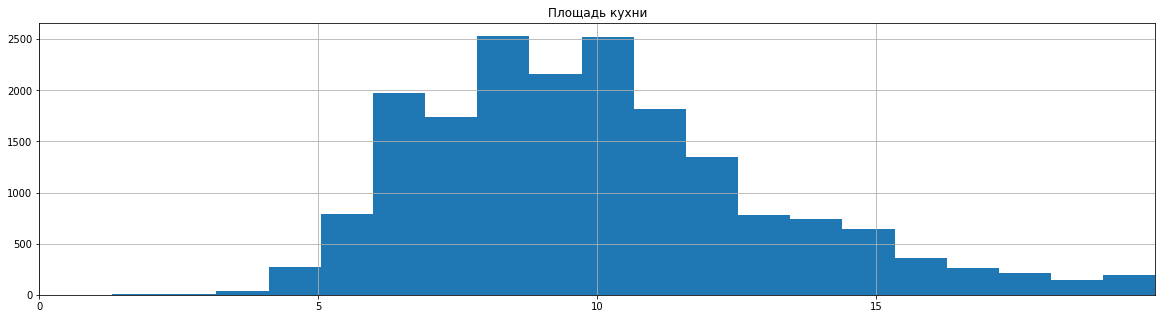

In [37]:
ax = data['kitchen_area'].hist(bins=20, figsize=(20, 5))
plt.title('Площадь кухни')
ax.set_xlim(0, 20)
plt.xticks(np.arange(0, 20, 5));

*Плоощадь кухни* распределение близко к нормальному. Настораживают значения в 1, 2 и 3 кв. м. Воможно, ошибки в данных.

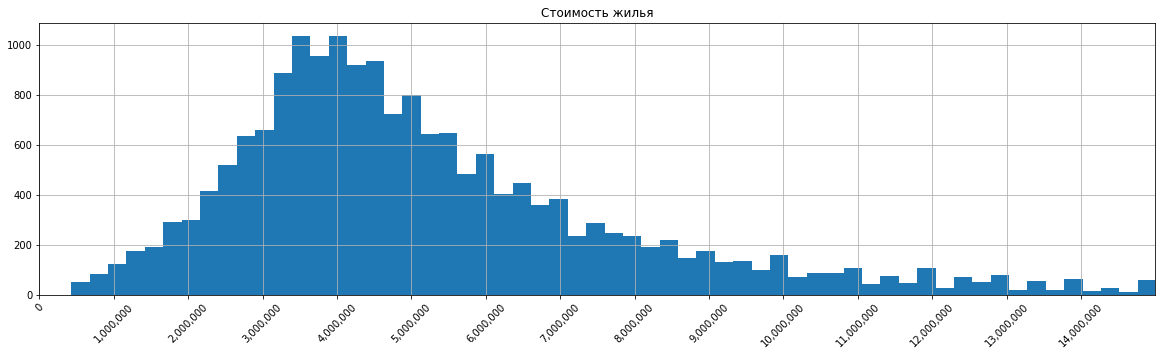

In [38]:
ax = data['last_price'].hist(bins=500, figsize=(20, 5))
plt.title('Стоимость жилья')
ax.set_xlim(0, 15000000)
plt.xticks(np.arange(0, 15000000, 1000000), rotation=45)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

Стоимость большинства квартир - до 15М, квартир дороже - сильно меньше. Распределение похоже на на нормальное с длинным хвостом справа. Пик в районе 4М. 

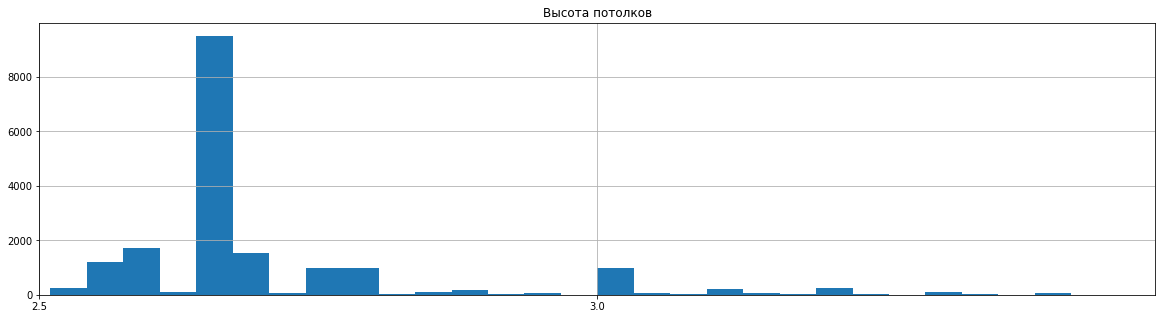

In [39]:
ax = data['ceiling_height'].hist(bins=30, figsize=(20, 5))
plt.title('Высота потолков')
ax.set_xlim(2.5, 3.5);
plt.xticks(np.arange(2.5, 3.5, 0.5));

Высота потолков в основном стандартная

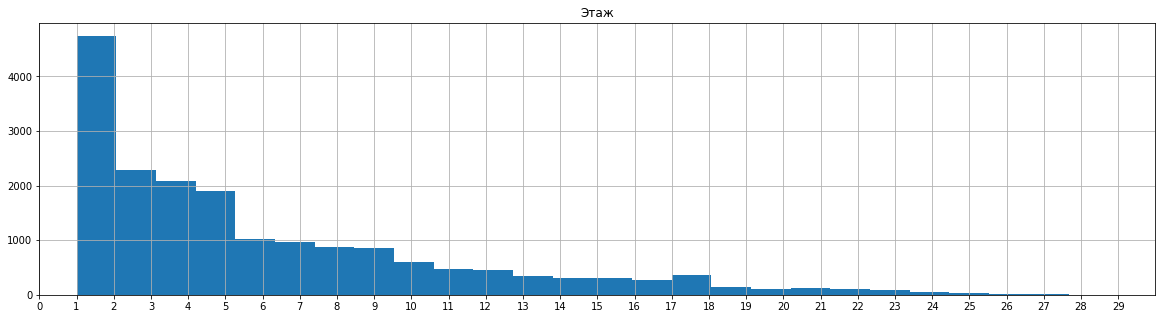

In [40]:
ax = data['floor'].hist(bins=30, figsize=(20, 5))
plt.title('Этаж')
ax.set_xlim(0, 30);
plt.xticks(np.arange(0, 30, 1));

Чем выше этаж, тем реже появляются объявления. Пик на первом этаже. Жить там не очень приятно, возможно, люди стремятся избавиться от таких квартир.

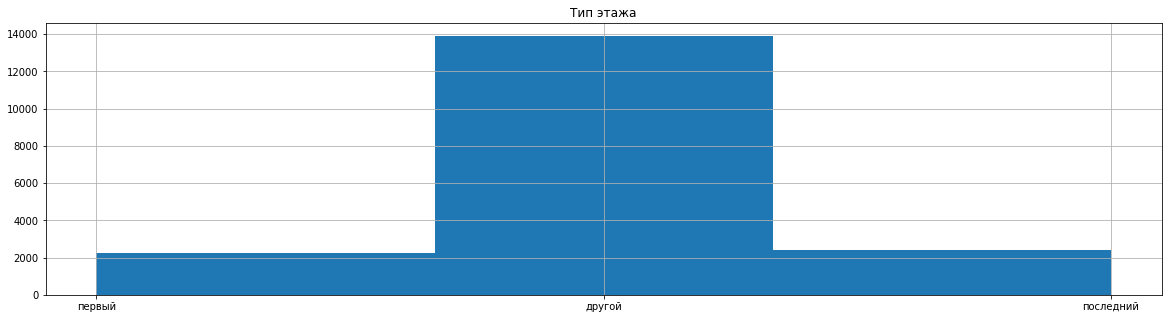

In [41]:
ax = data['floor_type'].hist(bins=3, figsize=(20, 5))
plt.title('Тип этажа');

Несмотря на то, что предыдущая гистограмма показала пик на первом этаже, оказалось, что таких квартир меньшинство. Это вполне логично, ведь "других" этажей в принципе больше, чем первых и последних.

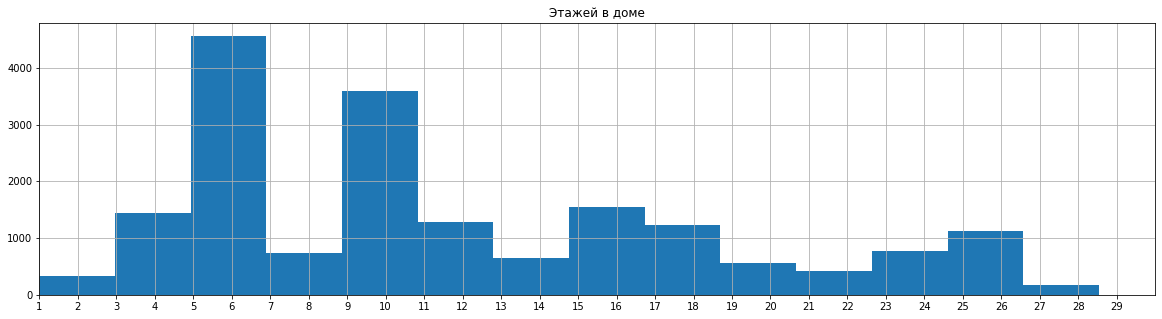

In [42]:
ax = data['floors_total'].hist(bins=30, figsize=(20, 5))
plt.title('Этажей в доме')
ax.set_xlim(1, 30);
plt.xticks(np.arange(1, 30, 1));

Этажность имеет несколько пиков. По всей видимости это связано со стандартами многоэтажного строительства. 

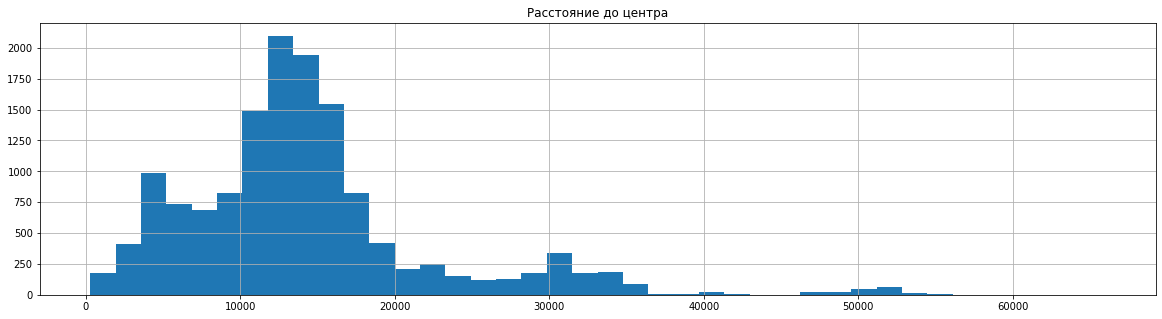

In [43]:
ax = data['cityCenters_nearest'].hist(bins=40, figsize=(20, 5))
plt.title('Расстояние до центра');

Часто расстояние до центра не превышает 20 км. Это говорит о том, что большинство объявлений из довольно крупных городов. Помним, что в нашем случае это Санкт-Петербург. 

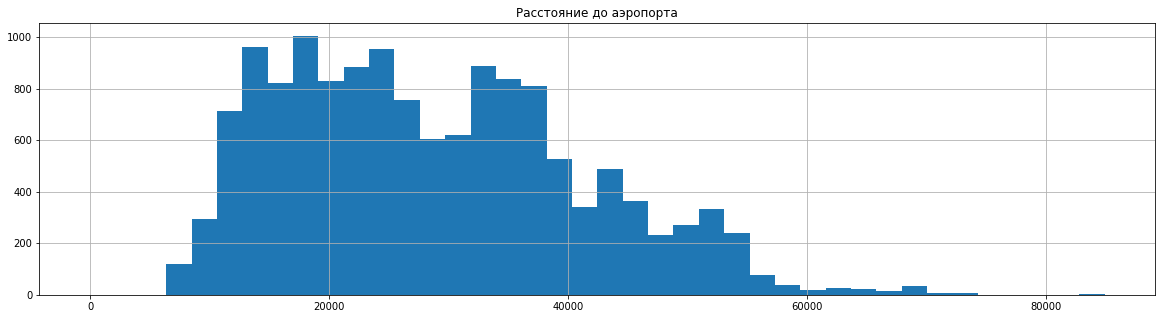

In [44]:
ax = data['airports_nearest'].hist(bins=40, figsize=(20, 5))
plt.title('Расстояние до аэропорта');

Аэропорты, как правило, существенно дальше центра города, выглядит обычно. 

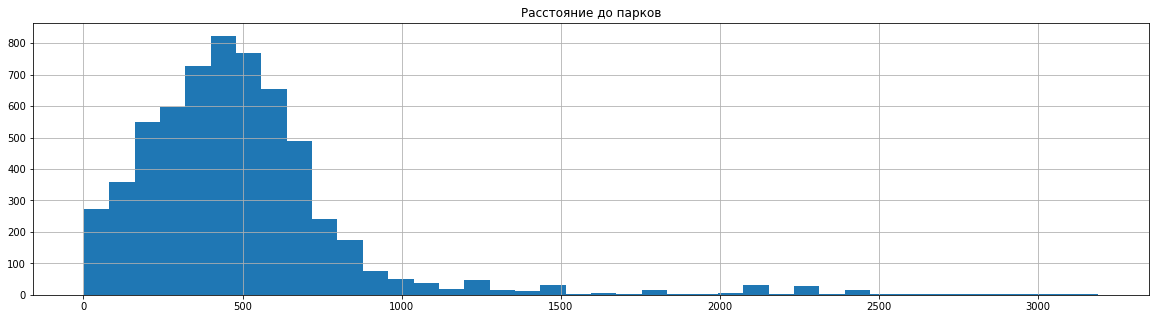

In [45]:
ax = data['parks_nearest'].hist(bins=40, figsize=(20, 5))
plt.title('Расстояние до парков');

Многие квартиры находятся неподалеку от парка. Это радует, значит, с озеленением в Санкт-Петербурге всё в порядке.

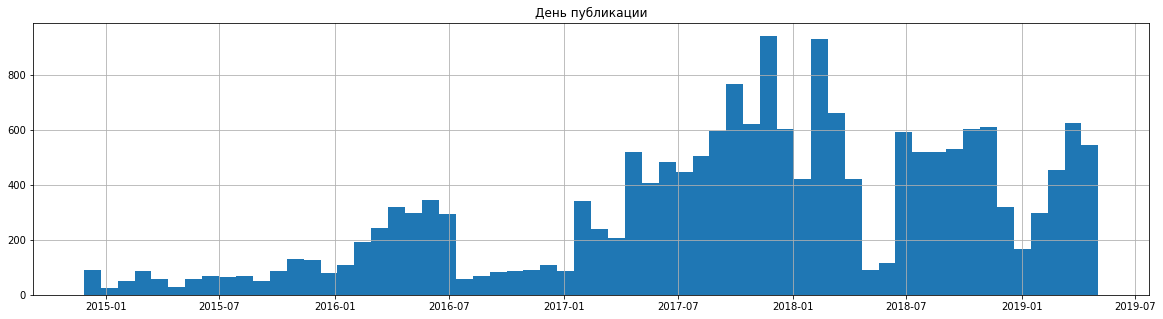

In [46]:
ax = data['first_day_exposition'].hist(bins=60, figsize=(20, 5))
plt.title('День публикации');

Чем ближе к настоящему, тем больше объявлений. Бывают пики и провалы, с чем они связаны, ответить затруднительно.

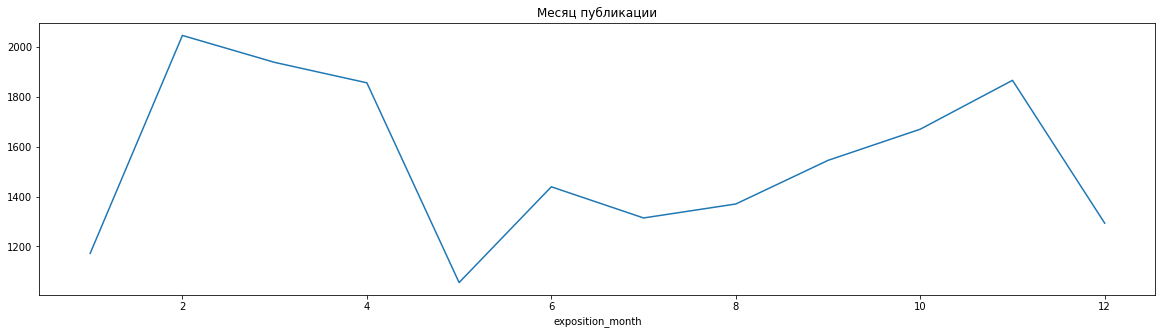

In [47]:
ax = data.groupby('exposition_month').agg('count')['exposition_weekday'].plot(kind='line', figsize=(20, 5))
plt.title('Месяц публикации');

*Месяц публикации* показывает, что большее количество публикаций приходится на холодные сезоны, за исключением просадки в канун нового года и новогодние праздники, что, опять же, нормально для любой интернет активности. Также на данные по месяца сыграл тот факт, что в представленном датасете 2019 год отражен не полностью

#### Скорость продажи квартиры

Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление

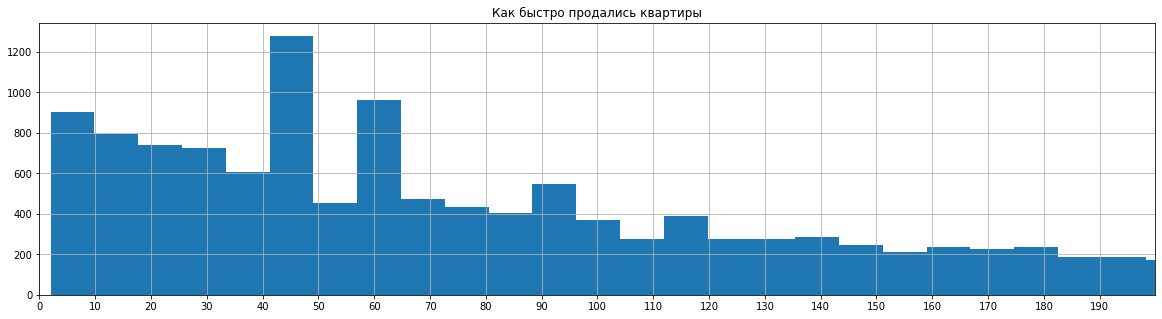

In [48]:
ax = data['days_exposition'].hist(bins=200, figsize=(20, 5))
ax.set_xlim(0, 200)
plt.title('Как быстро продались квартиры');
plt.xticks(np.arange(0, 200, 10));

In [49]:
print('Среднее время продажи: {} дней'.format(data['days_exposition'].mean().round()))
print('Медианное время продажи: {} дней\n'.format(data['days_exposition'].median()))
print('Первый квартиль: {} дней'.format(data['days_exposition'].quantile(0.25).round()))
print('Третий квартиль: {} дней'.format(data['days_exposition'].quantile(0.75).round()))

Среднее время продажи: 178.0 дней
Медианное время продажи: 94.0 дней

Первый квартиль: 45.0 дней
Третий квартиль: 227.0 дней


В среднем квартира продаётся за полгода. Половина всех продаж происходит в пределах трех месяцев. Продажу в течение полутора месяцев можно считать быстрой, дольше 7 месяцев - долгой. Интересны пики на 45, 60, 90 и 120 днях. Возможно, алгоритмы выше ранжируют такие объявления.

####  Факторы, влияющие на общую (полную) стоимость объекта

общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

In [50]:
cost_agg = data.pivot_table(index=['total_area', 'living_area', 'kitchen_area',
                                   'rooms', 'floor_type', 'exposition_weekday',
                                   'exposition_month', 'exposition_year'],
                            values='last_price',
                            aggfunc='mean').reset_index()

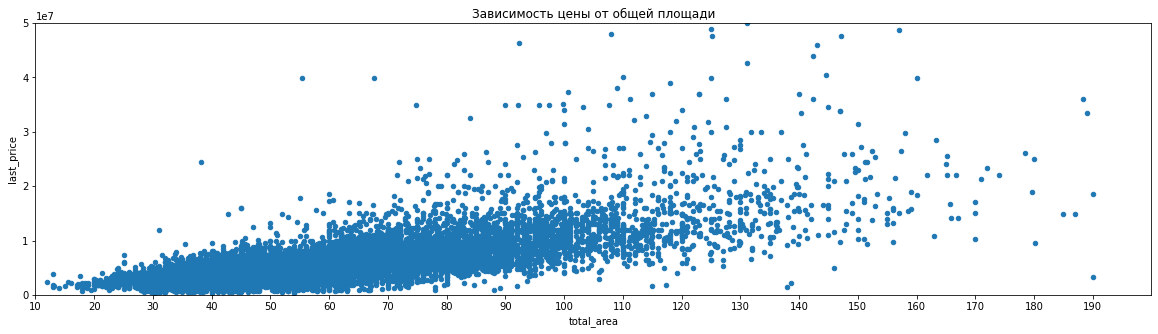

In [51]:
ax = cost_agg.plot(x='total_area', y='last_price', kind='scatter', figsize=(20, 5))
ax.set_xlim(10, 200)
ax.set_ylim(0, 50000000)
plt.xticks(np.arange(10, 200, 10))
plt.title('Зависимость цены от общей площади');

Цена прямо коррелирует c увеличением площади, что логично. Чем больше квадратных метров, тем выше цена жилья.

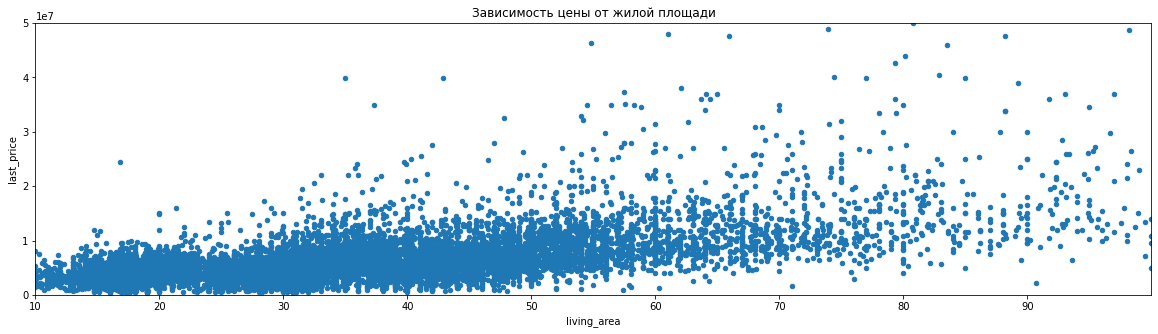

In [52]:
ax = cost_agg.plot(x='living_area', y='last_price', kind='scatter', figsize=(20, 5))
ax.set_xlim(10, 100)
ax.set_ylim(0, 50000000)
plt.xticks(np.arange(10, 100, 10))
plt.title('Зависимость цены от жилой площади');

Корреляция цены с жилой площадью тоже положительна, хоть и не так явно выражена. 

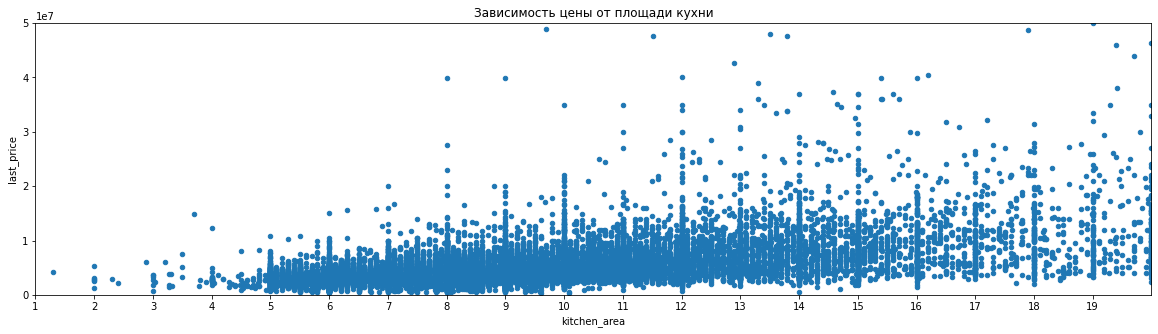

In [53]:
ax = cost_agg.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(20, 5))
ax.set_xlim(1, 20)
ax.set_ylim(0, 50000000)
plt.xticks(np.arange(1, 20, 1))
plt.title('Зависимость цены от площади кухни');

Корреляция цены с площадью кухни тоже положительна тоже не так ярко выражена.

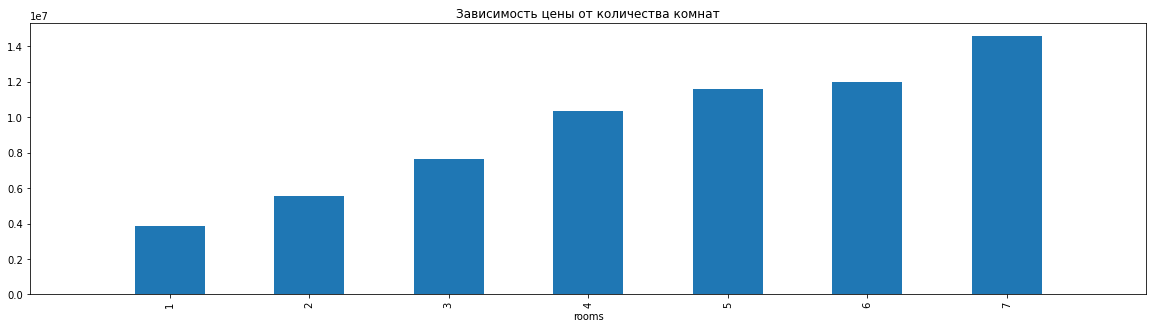

In [54]:
ax = cost_agg.groupby('rooms').agg('mean')['last_price'].plot(kind='bar', figsize=(20, 5))
ax.set_xlim(-1, 7)
plt.xticks(np.arange(0, 7, 1))
plt.title('Зависимость цены от количества комнат');

Чем больше комнат, тем выше средняя цена. Логично, ведь, как правило и площадь тоже выше.

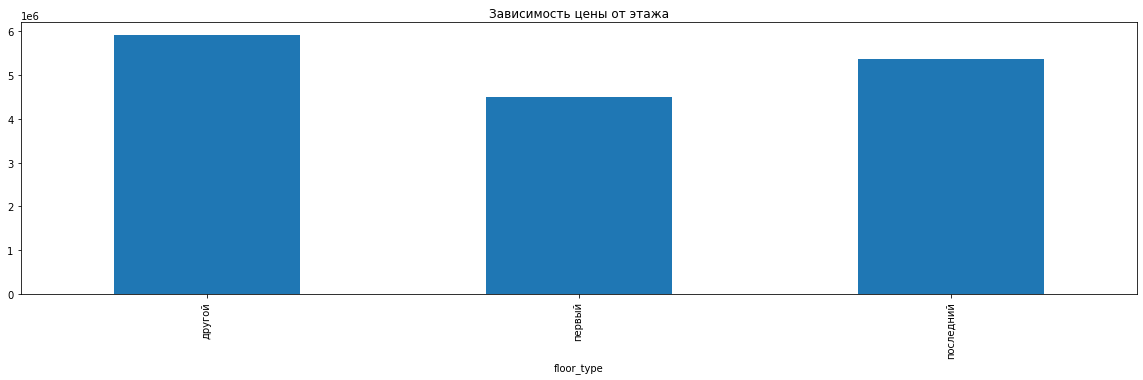

In [55]:
ax = cost_agg.groupby('floor_type').agg('mean')['last_price'].plot(kind='bar', figsize=(20, 5))
plt.title('Зависимость цены от этажа');

Первый этаж зачастую дешевле, это логично, ведь на первом этаже очень шумно и пыльно. 

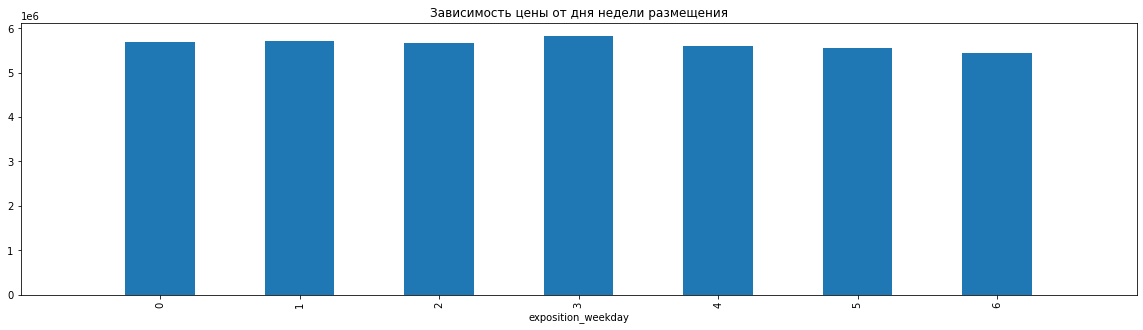

In [56]:
ax = cost_agg.groupby('exposition_weekday').agg('mean')['last_price'].plot(kind='bar', figsize=(20, 5))
ax.set_xlim(-1, 7)
plt.xticks(np.arange(0, 7, 1))
plt.title('Зависимость цены от дня недели размещения');

Было бы странно, если бы цена зависела от дня недели, в который выставлено объявление. 

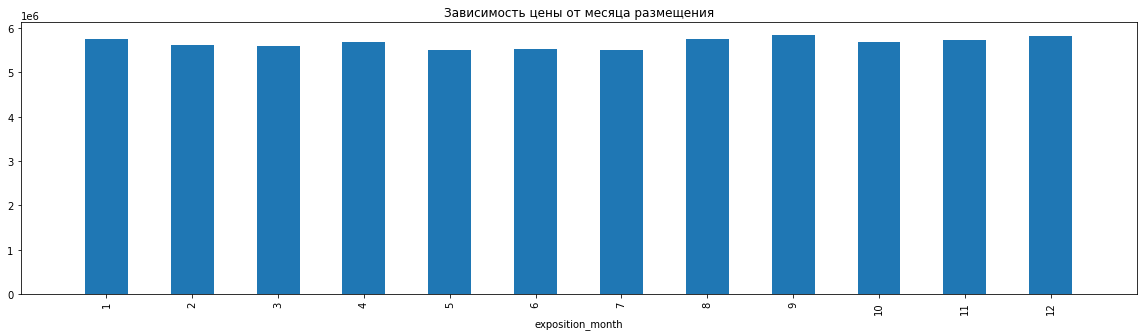

In [57]:
ax = cost_agg.groupby('exposition_month').agg('mean')['last_price'].plot(kind='bar', figsize=(20, 5))
ax.set_xlim(-1, 12)
plt.xticks(np.arange(0, 12, 1))
plt.title('Зависимость цены от месяца размещения');

Корреляции нет.

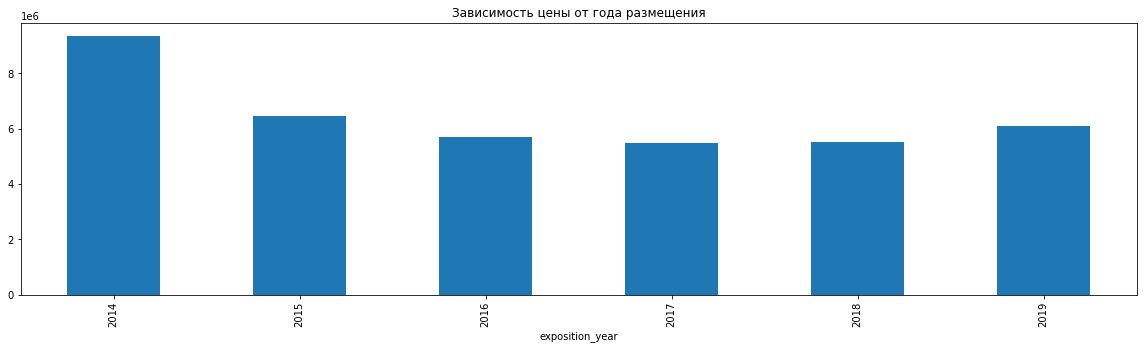

In [58]:
ax = cost_agg.groupby('exposition_year').agg('mean')['last_price'].plot(kind='bar', figsize=(20, 5))
plt.title('Зависимость цены от года размещения');

Все мы знаем, что с годами недвижимость дорожает, особенно в крупных городах. Сейчас корреляции не видно, возможно, данные неполны. Пик в 2014 году может указывать на резкое ослабление рубля с одновременным ростом неопределённости в следствие аннексии Крымского полуострова и взлете стоимости жилья в рублях. 

In [59]:
cost_agg.corr()

,total_area,living_area,kitchen_area,rooms,exposition_weekday,exposition_month,exposition_year,last_price
total_area,1.000000,0.936111,0.530309,0.809684,-0.012821,0.011132,-0.064885,0.695708
living_area,0.936111,1.000000,0.322939,0.887587,-0.008292,0.005303,-0.060533,0.609603
kitchen_area,0.530309,0.322939,1.000000,0.154365,-0.013645,0.018655,-0.026116,0.490763
rooms,0.809684,0.887587,0.154365,1.000000,-0.003516,0.001933,-0.049764,0.432987
exposition_weekday,-0.012821,-0.008292,-0.013645,-0.003516,1.000000,0.022662,0.000549,-0.013222
exposition_month,0.011132,0.005303,0.018655,0.001933,0.022662,1.000000,-0.258636,0.010396
exposition_year,-0.064885,-0.060533,-0.026116,-0.049764,0.000549,-0.258636,1.000000,-0.023016
last_price,0.695708,0.609603,0.490763,0.432987,-0.013222,0.010396,-0.023016,1.000000


Данные о корреляции во многом сходятся с выводами, полученными при анализе графиков.

#### Средняя цена квадратного метра в 10 населенных пунктах с самым большим количеством объявлений

In [60]:
top_10 = data.groupby('locality_name')['last_price'].agg('count').sort_values(ascending=False).head(10).index

In [61]:
data[data['locality_name'].isin(top_10)].groupby('locality_name')['meter_price'].mean().sort_values(ascending=False)

locality_name
Санкт-Петербург    111884.299661
Пушкин             103443.507962
Кудрово             95562.378571
Парголово           90235.535004
Мурино              86013.589156
Шушары              78634.521536
Колпино             75245.558709
Всеволожск          68893.671827
Гатчина             68887.890393
Выборг              58066.516524
Name: meter_price, dtype: float64

#### Средяя цена каждого километра до центра Санкт-Петербурга

In [63]:
center_nearesr_price = (data[data['locality_name'] == 'Санкт-Петербург']
                        .groupby('cityCenters_nearest_km')
                        .agg({'last_price':'mean'})
                        .sort_values(by = 'cityCenters_nearest_km'))

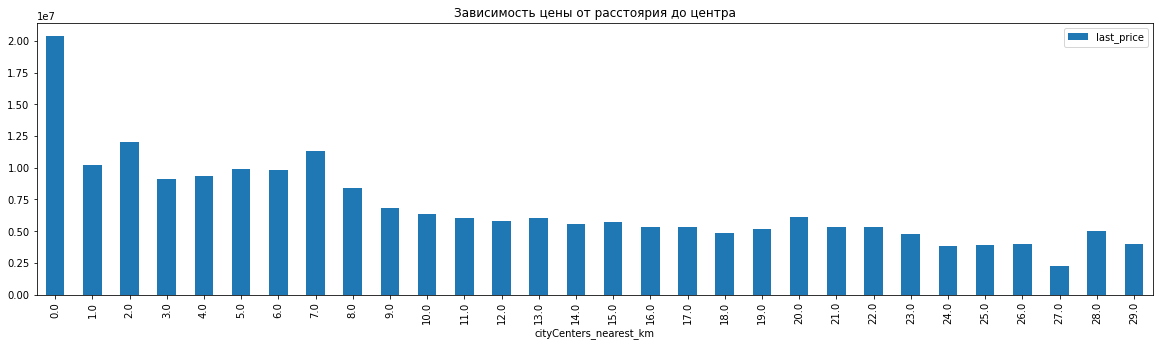

In [64]:
ax = center_nearesr_price.plot(kind='bar', figsize=(20, 5))
plt.title('Зависимость цены от расстоярия до центра');

- Если до центра менее километра, жильё сильно дороже, чем если 1 км. и более;
- 1 км тоже имеют довольно высокую цену по сравнению с остальными;
- Следующую отсечку можно сделать на 7 км;

В целом чем дальше от центра, тем дороже за некоторыми исключениями. 

### Общий вывод

**Что мы сделали:**
- Заполнили пропуски в данных;
- Исправили явные ошибки в объявлениях;
- Удалили подозрительные и некорректно заполненные объявления, исправить которые не удалось;
- Визуально оценили распределение данных в различных срезах;
- Нашли корреляции и зависимости в данных, выяснили, что главным образом влияет на стоимость жилья;

**Выводы:**
- Цена на жильё сильно зависит от площади: общей, жилой, площади кухни. Также в случае Санкт-Петербурга, и с высокой долей вероятности других крупных городов тоже, на цену влияет удаленность от центра города; 
- Первый и последний этаж в среднем стоят дешевле промежуточных;
- На рынке очень много однокомнатных квартир;

**Рекомендации:**
- Расстояние от центра, общую, жилую и площадь кухни следует выводить в снипеты объявления, поскольку, это самые важные показатели;
- Можно разработать систему рекомендаций, которая будет показывать пользователям жилье на таком же расстоянии или ближе к центру, но дешевле. Это может повысить глубину просмотра и продажи;
- Часто в объявлениях не заполняются расстояния до центра, парков, аэропорта. Можно разработать систему, которая будет сама вычислять эти расстояния, ориентируясь на адрес жилья. Это снизит напряжение пользователей, которые публикуют объявления, а также повысит удовлетворенность пользователей, которые ищут жильё